In [2]:
import pandas as pd

In [3]:
#загузка используемых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

Проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

Загружаем данные о заказах, парсим даты сразу

In [4]:
orders_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/First_project/olist_orders_dataset.csv', 
                             parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date'
                                          , 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders_dataset.head(5)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [5]:
orders_dataset.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Группируем данные о покупателях и заказах

In [6]:
orders_dataset_group = orders_dataset.groupby(['customer_id', 'order_status'], as_index = False).agg({'order_id':'count'})

In [7]:
orders_dataset_group.max()

customer_id     ffffe8b65bbe3087b653a978c870db99
order_status                         unavailable
order_id                                       1
dtype: object

Загружаем подробные данные о пользователях 

In [8]:
list_customers_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/First_project/olist_customers_dataset.csv')
list_customers_dataset.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [9]:
list_customers_dataset.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

соединяем таблицу заказов с данные об уникальных пользователях 

In [10]:
orders_w_unique_id = orders_dataset.merge(list_customers_dataset, how='outer', on='customer_id')

In [11]:
orders_w_unique_id['order_id'].nunique()

99441

в качестве покупки будем считать, что покупкой являются все заказы, статус которых не был отменен 

In [12]:
purchases_unique_id = orders_w_unique_id.query('order_status != "canceled"')
purchases_w_unique_id_group = purchases_unique_id.groupby('customer_unique_id', as_index = False).agg({'order_id':'count'})

In [13]:
orders_w_unique_id.query('order_status != "canceled"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [14]:
purchases_w_unique_id_group.order_id.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 17])

In [15]:
purchases_w_unique_id_group

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1
95556,fffea47cd6d3cc0a88bd621562a9d061,1
95557,ffff371b4d645b6ecea244b27531430a,1
95558,ffff5962728ec6157033ef9805bacc48,1


In [16]:
purchases_w_unique_id_group[purchases_w_unique_id_group['order_id'] > 1]

,customer_unique_id,order_id
106,004288347e5e88a27ded2bb23747066c,2
124,004b45ec5c64187465168251cd1c9c2f,2
248,00a39521eb40f7012db50455bf083460,2
311,00cc12a6d8b578b8ebd21ea4e2ae8b27,2
412,011575986092c30523ecb71ff10cb473,2
...,...,...
95223,ff22e30958c13ffe219db7d711e8f564,2
95276,ff44401d0d8f5b9c54a47374eb48c1b8,2
95382,ff8892f7c26aa0446da53d01b18df463,2
95400,ff922bdd6bafcdf99cb90d7f39cea5b3,3


сколько пользователей, которые совершили покупку только один раз

In [17]:
purchases_w_unique_id_group.query('order_id == 1').order_id.sum()

92636

Считаем, что unavailable это совершенный и оплаченный заказ, можем предположмть, что товар не был найден на складе (недоступный товар) или был утерян. 

In [18]:
orders_w_unique_id.query('order_status == "unavailable"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27,9004096d8ffc515d4189e661fc4bcb84,3759,sao paulo,SP
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19,0aa3b096dc796c251f9b36a822051ed6,14750,pitangueiras,SP
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ


In [19]:
orders_w_unique_id.query('order_status == "canceled"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8ea097b1824dbd4d17af71b0afe04301,5514,sao paulo,SP
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,c4ebedb09beb89cc0314c5c0c33f8053,9961,diadema,SP
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,11c3d6c93dea6ce86769a4835c171bd9,87013,maringa,PR
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,08642cd329066fe11ec63293f714f2f8,33030,santa luzia,MG
...,...,...,...,...,...,...,...,...,...,...,...,...
98791,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,78a159045124eb7601951b917a42034f,89111,gaspar,SC
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10,13d7bd0b05e18b00f415221b3bb69348,9810,sao bernardo do campo,SP
99143,6560fb10610771449cb0463c5ba12199,0d07d0a588caf93cc66b7a8aff86d2fe,canceled,2017-10-01 22:26:25,2017-10-01 22:35:22,NaT,NaT,2017-10-27,0f75924cbbe60142068f4029d744b724,82310,curitiba,PR
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP


In [21]:
orders_w_unique_id.query('order_id == "8e24261a7e58791d10cb1bf9da94df5c"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC


In [22]:
orders_w_unique_id.query('customer_id == "64a254d30eed42cd0e6c36dddb88adf0"') 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

Рассмотрим распределение статусов заказов за все время

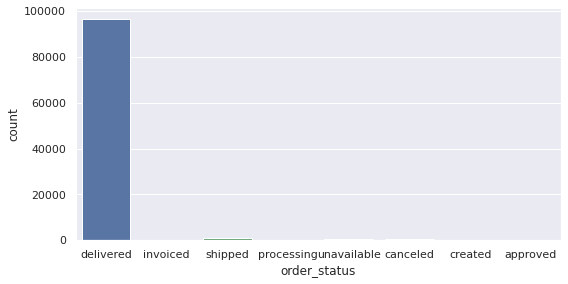

In [23]:
sns.set(rc={'figure.figsize':(8.7,4.27)})
sns.countplot(data = orders_dataset, x='order_status')

In [24]:
status = orders_dataset.groupby(['order_status'], as_index = False).agg({'order_id':'count'})
status

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [25]:
orders_dataset.query('order_status != "delivered"').head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


Добавляем колонку с месяцем совершения покупки

In [26]:
orders_dataset['order_purchase_month'] = orders_dataset.order_purchase_timestamp.dt.strftime('%Y-%m')

Сортируем значения по времени

In [27]:
not_delivered_permonth = orders_dataset.query('order_status in ["canceled", "unavailable"]') \
.sort_values('order_purchase_month')
not_delivered_permonth.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,2016-09
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,2016-09
60706,9bd5312d12f48b04a460f702baff3d8c,4d145fd1d3245cbb3697dd41b4bcf19b,canceled,2016-10-06 20:43:30,NaT,NaT,NaT,2016-11-16,2016-10
79275,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07,2016-10
53688,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaT,NaT,NaT,2016-10-24,2016-10


In [28]:
not_delivered_permonth['purchase_num'] = 1
not_delivered_permonth.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,purchase_num
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,2016-09,1
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,2016-09,1
60706,9bd5312d12f48b04a460f702baff3d8c,4d145fd1d3245cbb3697dd41b4bcf19b,canceled,2016-10-06 20:43:30,NaT,NaT,NaT,2016-11-16,2016-10,1
79275,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07,2016-10,1
53688,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaT,NaT,NaT,2016-10-24,2016-10,1


In [29]:
undelivered_purchases = not_delivered_permonth.groupby(['order_status', 'order_purchase_month'], as_index = False) \
    .agg({'purchase_num':'count'}).sort_values('order_purchase_month')
undelivered_purchases.head()

,order_status,order_purchase_month,purchase_num
0,canceled,2016-09,2
1,canceled,2016-10,24
24,unavailable,2016-10,7
2,canceled,2017-01,3
25,unavailable,2017-01,10


Найдем какое кол-во заказов в месяц в среднем не доставляется по разным причинам, округленное в большую сторону

In [30]:
(np.ceil(undelivered_purchases.groupby(['order_status'], as_index = False) \
    .agg({'purchase_num':'count'}).purchase_num.mean()))

23.0

Детализация по недоставленным товарам по причинам

In [31]:
undelivered_purchases.groupby(['order_status'], as_index = False) \
    .agg({'purchase_num':'mean'})

,order_status,purchase_num
0,canceled,26.041667
1,unavailable,29.000000


Сколько всего недоставленных товаров по месяцам.

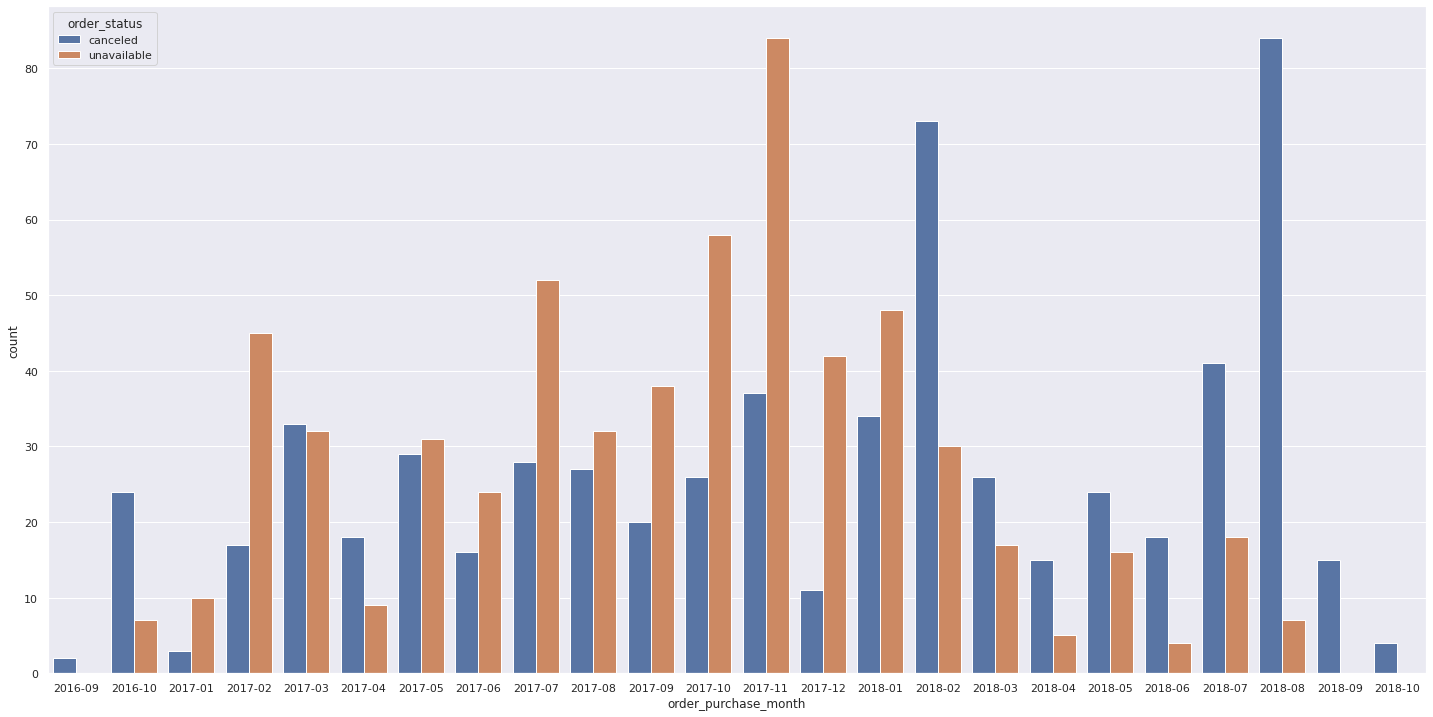

In [32]:
sns.set(rc={'figure.figsize':(24.7,12.27)})
sns.countplot(data = not_delivered_permonth, x='order_purchase_month', hue='order_status')

### 3 По каждому товару определить, в какой день недели товар чаще всего покупается.

Загружаем данные по товарам

In [33]:
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-korovina/First_project/olist_order_items_dataset.csv',
           parse_dates=['shipping_limit_date'])

In [34]:
items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [35]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Объединяем 2 таблицы, чтобы получить данные о времени совершения заказа

In [36]:
items_buy_day = items.merge(orders_dataset, on='order_id')
items_buy_day.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02


In [37]:
items_buy_day.order_purchase_timestamp.dt.day_name()

0         Wednesday
1         Wednesday
2            Sunday
3         Wednesday
4          Saturday
            ...    
112645       Monday
112646     Saturday
112647       Monday
112648       Monday
112649     Saturday
Name: order_purchase_timestamp, Length: 112650, dtype: object

Добавляем столбец с данными о дне недели совершения покупки

In [38]:
items_buy_day = items_buy_day.assign(buy_day = items_buy_day.order_purchase_timestamp.dt.day_name())

In [39]:
items_buy_day.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,buy_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,Saturday


Создаем таблицу сгруппированную по продуктам и дню покупки

In [40]:
product_buy_day = items_buy_day.groupby(['product_id', 'buy_day'], as_index=False).agg({'order_id':'count'}) \
    .sort_values(['product_id', 'buy_day'], ascending=False) 

Добавляем столбец с данными о дне неледели и максимальном количестве проданного товара

In [93]:
product_buy_day['max_product'] = product_buy_day.groupby(['product_id'])['order_id'].transform('max')
product_buy_day.sort_values('max_product', ascending=False)

,product_id,buy_day,order_id,max_product
15902,422879e10f46682990de24d770e7f83d,Wednesday,93,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67,67
...,...,...,...,...
37982,9fa1e97015f5c5e76add50079bb0ab44,Wednesday,1,1
37983,9fa383a47388caa20228a1b5e238472b,Monday,1,1
37984,9fa7e05ae5cddeb74ff2fe5046b742db,Friday,1,1
37988,9faadcbfeed012c5a26f8cda328af7f7,Thursday,1,1


Находим в какой день недели товар чаще всего покупается. В двнных для некоторых товаров будут несколько дней в неделе с одинаковым (max) кол-вом проданного товара

In [42]:
product_buy_day = product_buy_day[product_buy_day['order_id'] == product_buy_day['max_product']]#.drop_duplicates(subset='product_id')

In [43]:
product_buy_day

,product_id,buy_day,order_id,max_product
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2,2
61224,fff9553ac224cec9d15d49f5a263411f,Friday,1,1
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday,1,1
61222,fff6177642830a9a94a0f2cba5e476d1,Sunday,1,1
...,...,...,...,...
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1


Находим дублирующиеся товары и дни недели с пиковыми продажами

In [44]:
product_buy_day[product_buy_day.duplicated(subset='product_id')].sort_values('product_id')

,product_id,buy_day,order_id,max_product
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
26,002159fe700ed3521f46cfcf6e941c76,Saturday,2,2
42,0030e635639c898b323826589761cf23,Friday,1,1
44,003128f981470c3e5a2e7445e4a771cd,Saturday,1,1
51,003dbcabcf8e3231de657c7d9f9a5eba,Tuesday,1,1
...,...,...,...,...
61201,ffe0fc4e02c3559643ac063fa5cf9d07,Friday,1,1
61203,ffe75578163d45caa52bca3529cb511e,Thursday,1,1
61205,ffe8083298f95571b4a66bfbc1c05524,Friday,1,1
61212,ffef256879dbadcab7e77950f4f4a195,Monday,2,2


In [45]:
product_buy_day[product_buy_day.duplicated(subset='product_id', keep='last')].sort_values('product_id')

,product_id,buy_day,order_id,max_product
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1
28,002159fe700ed3521f46cfcf6e941c76,Tuesday,2,2
43,0030e635639c898b323826589761cf23,Tuesday,1,1
45,003128f981470c3e5a2e7445e4a771cd,Sunday,1,1
52,003dbcabcf8e3231de657c7d9f9a5eba,Wednesday,1,1
...,...,...,...,...
61202,ffe0fc4e02c3559643ac063fa5cf9d07,Wednesday,1,1
61204,ffe75578163d45caa52bca3529cb511e,Wednesday,1,1
61206,ffe8083298f95571b4a66bfbc1c05524,Tuesday,1,1
61214,ffef256879dbadcab7e77950f4f4a195,Tuesday,2,2


In [46]:
product_buy_day[product_buy_day['product_id'] == '35afc973633aaeb6b877ff57b2793310'] 
# смотрим в какие дни недели были максимальные продажи товара из предыдущей ячейки

,product_id,buy_day,order_id,max_product
12819,35afc973633aaeb6b877ff57b2793310,Thursday,31,31
12816,35afc973633aaeb6b877ff57b2793310,Monday,31,31


### 4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

Добавляем колонки с номером месяца и номером недели  

In [94]:
items_buy_day['month_number'] = items_buy_day.order_purchase_timestamp.dt.month

In [101]:
items_buy_day['week_number'] = items_buy_day.order_purchase_timestamp.dt.week
items_buy_day['days_in_month'] = items_buy_day.order_purchase_timestamp.dt.days_in_month
items_buy_day['weeks_in_month'] = items_buy_day['days_in_month'] / 7
items_buy_day.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,buy_day,month_number,week_number,days_in_month,weeks_in_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,Wednesday,9,37,30,4.285714
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,Wednesday,4,17,30,4.285714
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,Sunday,1,2,31,4.428571
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,Wednesday,8,32,31,4.428571
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,Saturday,2,5,28,4.000000


In [99]:
items_buy_day.order_purchase_timestamp.dt.days_in_month

0         30
1         30
2         31
3         31
4         28
          ..
112645    30
112646    31
112647    31
112648    31
112649    30
Name: order_purchase_timestamp, Length: 112650, dtype: int64

Группируем по клиенту, месяцу и неделе. 

In [102]:
purchases_week = items_buy_day.groupby(['customer_id', 'month_number', 'weeks_in_month'], as_index=False).agg({'order_id':'count'})

In [107]:
purchases_week['mean_in_week_per_month'] = purchases_week['order_id'] / purchases_week['weeks_in_month']

Находим сколько у каждого из пользователей в среднем покупок в неделю (по месяцам) (mean_in_week_per_month).

In [109]:
purchases_week.sort_values('mean_in_week_per_month', ascending=False)

,customer_id,month_number,weeks_in_month,order_id,mean_in_week_per_month
73568,be1b70680b9f9694d8c70f41fa3dc92b,2,4.000000,20,5.000000
97220,fc3d1daec319d62d49bfb5e1f83123e9,7,4.428571,21,4.741935
73311,bd5d39761aa56689a265d95d8d32b8be,8,4.428571,20,4.516129
6456,10de381f8a8d23fff822753305f71cae,11,4.285714,15,3.500000
64553,a7693fba2ff9583c78751f2b66ecab9d,2,4.000000,14,3.500000
...,...,...,...,...,...
22410,3a0630ca3cabd7ede33edb0b6ddb8239,1,4.428571,1,0.225806
58015,969bfe4cf327c55f3dedaf7ba053a310,8,4.428571,1,0.225806
58016,969cc483264bc757e873483f0f9de9d2,7,4.428571,1,0.225806
22408,3a06088ff3ab85c7f1912347708c035a,5,4.428571,1,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

In [53]:
orders_w_unique_id['order_purchase_month'] = orders_w_unique_id.order_purchase_timestamp.dt.strftime('%Y-%m')

In [54]:
customers_pre_first_purches = orders_w_unique_id.groupby(['customer_unique_id'], as_index=False).agg({'order_purchase_timestamp': 'min'})

Найдём дату первой покупки

In [55]:
customers_pre_first_purches.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


Отмеряем 3 месяца чтобы узнать дату когда нужно проверить возврат

In [56]:
customers_pre_first_purches['order_purchase_timestamp_check'] = (
    customers_pre_first_purches['order_purchase_timestamp'] + pd.Timedelta('91 days'))

In [57]:
customers_pre_first_purches.head()

,customer_unique_id,order_purchase_timestamp,order_purchase_timestamp_check
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-08-09 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-08-06 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-06-09 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2018-01-11 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2018-02-13 19:45:42


In [58]:
customers_pre_first_purches['order_purchase_timestamp_check'] = customers_pre_first_purches['order_purchase_timestamp_check'].dt.strftime('%Y-%m')
customers_pre_first_purches['order_purchase_timestamp'] = customers_pre_first_purches['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [59]:
customers_pre_first_purches.head()

,customer_unique_id,order_purchase_timestamp,order_purchase_timestamp_check
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-08
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,2018-08
2,0000f46a3911fa3c0805444483337064,2017-03,2017-06
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2018-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11,2018-02


Делаем временную таблицу где будем хранить суммарные продажи в месяц для каждого клиента

In [60]:
temp = orders_w_unique_id.groupby(['customer_unique_id', 'order_purchase_month'], as_index=False).agg({'order_id': 'count'})

In [61]:
temp.head()

,customer_unique_id,order_purchase_month,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


Присоединяем продажи по месяцу по которому нужно проверить возврат клиента +3 месяца

In [62]:
result = pd.merge(customers_pre_first_purches, temp, left_on=['customer_unique_id', 'order_purchase_timestamp_check'],
         right_on=['customer_unique_id', 'order_purchase_month'], how='left')

Считаем, что важно само возващение клиента, а не количество повторных покупок

In [63]:
result['order_id'] = result['order_id'].fillna(0)
result.loc[result['order_id'] >= 1, 'order_id'] = 1

In [64]:
result

,customer_unique_id,order_purchase_timestamp,order_purchase_timestamp_check,order_purchase_month,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-08,NaN,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,2018-08,NaN,0.0
2,0000f46a3911fa3c0805444483337064,2017-03,2017-06,NaN,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2018-01,NaN,0.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11,2018-02,NaN,0.0
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,2017-09,NaN,0.0
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12,2018-03,NaN,0.0
96093,ffff371b4d645b6ecea244b27531430a,2017-02,2017-05,NaN,0.0
96094,ffff5962728ec6157033ef9805bacc48,2018-05,2018-08,NaN,0.0


In [65]:
result = result.groupby('order_purchase_timestamp', as_index=False).agg({'customer_unique_id': 'count', 'order_id': 'sum'}).sort_values(by='order_id', ascending=False)

Получаем долю возвращаемости retention_rate, делим число вернувшихся order_id на размер когорты customer_unique_id

In [66]:
result['retention_rate'] = result['order_id'] / result['customer_unique_id']
result = result.sort_values(by='retention_rate', ascending=False)

In [67]:
kogorta = result.query('"2017-12" > order_purchase_timestamp > "2017-01"')

In [68]:
kogorta

,order_purchase_timestamp,customer_unique_id,order_id,retention_rate
5,2017-03,2636,11.0,0.004173
7,2017-05,3596,14.0,0.003893
8,2017-06,3139,12.0,0.003823
11,2017-09,4130,12.0,0.002906
10,2017-08,4184,11.0,0.002629
9,2017-07,3894,9.0,0.002311
6,2017-04,2352,4.0,0.001701
13,2017-11,7304,12.0,0.001643
4,2017-02,1752,2.0,0.001142
12,2017-10,4470,5.0,0.001119


### 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (23 балла)

In [69]:
purchases = orders_w_unique_id.query('order_status != "canceled"')

In [70]:
purchases = purchases.merge(items, on='order_id')

In [71]:
orders_w_unique_id.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [72]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


The RFM method 
It analyzes customers' behavior on three parameters:
Recency: How recent is the last purchase of the customer.
Frequency: How often the customer makes a purchase.
Monetary: How much money does the customer spends.

Methodology
To get the RFM score of a customer, we need to first calculate the R, F and M scores on a scale from 1 (worst) to 5 (best).

calculate Recency = number of days since last purchase
calculate Freqency = number of purchases during the studied period (usually one year)
calculate Monetary = total amount of purchases made during the studied period
find quintiles for each of these dimensions
give a grade to each dimension depending in which quintiles it stands
combine R, F and M scores to get the RFM score
map RF scores to segments

In [73]:
from datetime import timedelta
import matplotlib.pyplot as plt

In [74]:
print('{:,} rows; {:,} columns'.format(purchases.shape[0], purchases.shape[1]))

112,108 rows; 19 columns


In [75]:
print('{:,} invoices don\'t have a customer id'.format(purchases[purchases.customer_unique_id.isnull()].shape[0]))
#purchases.customer_unique_id.isnull().sum()

0 invoices don't have a customer id


In [76]:
print('Orders from {} to {}'.format(purchases['order_purchase_timestamp'].min(),
                                    purchases['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57


In [77]:
purchases['order_id'].value_counts()

8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
                                    ..
8d40f6aeb11aa6d03d17b3fa59b14fbe     1
090d23542dd542b9a9e25fa9d5d9e528     1
87c8ac1de72a771acb26702730aba866     1
0576822a11b3068cce2e3c8551e4e327     1
18b3b5404f523379b23e3eed42639acc     1
Name: order_id, Length: 98205, dtype: int64

In [78]:
orders = purchases.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id']) \
    .agg({'price': 'sum'}).reset_index()

In [79]:
orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [80]:
NOW = orders['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 09:06:57')

In [81]:
period = 365

Поскольку в данных заказы в период с 2016-09-04 21:15:19 по 2018-09-03 09:06:57, возьмем календарный год 2017.
Посчитаем Recency, Frequency и Monetary для каждого покупателя. Добавим колонку с данными о кол-ве дней с последней покупки (NOW)

In [82]:
orders['DaysSinceOrder'] = orders['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

In [83]:
orders

,order_id,order_purchase_timestamp,customer_unique_id,price,DaysSinceOrder
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90,356
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90,495
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00,232
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99,26
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90,576
...,...,...,...,...,...
98200,fffc94f6ce00a00581880bf54a75a037,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,299.99,133
98201,fffcd46ef2263f404302a634eb57f7eb,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,350.00,51
98202,fffce4705a9662cd70adb13d4a31832d,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,99.90,315
98203,fffe18544ffabc95dfada21779c9644f,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,55.99,385


создаем новую таблицу rfm с Recency и Frequency.

In [84]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'order_purchase_timestamp': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency'}, inplace=True)
rfm

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1
2,0000f46a3911fa3c0805444483337064,542,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1
4,0004aac84e0df4da2b147fca70cf8255,293,1
...,...,...,...
94984,fffcf5a5ff07b0908bd4e2dbc735a684,452,0
94985,fffea47cd6d3cc0a88bd621562a9d061,267,1
94986,ffff371b4d645b6ecea244b27531430a,573,0
94987,ffff5962728ec6157033ef9805bacc48,124,1


In [85]:
Monetary = orders[orders['order_purchase_timestamp'] >= NOW - timedelta(days=period)] \
    .groupby(['customer_unique_id'], as_index=False).agg({'price':'sum'}).rename(columns={'price':'Monetary'})

In [86]:
rfm = rfm.merge(Monetary, on='customer_unique_id')

Используем схему из примера для установления параметра R, F and M scores.
We can use quintiles. Each quintiles contains 20% of the population. Using quintiles is more flexible as the ranges will adapt to the data and would work across different industries or if there's any change in expected customer behavior.

In [87]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 75.0, 0.4: 143.0, 0.6: 207.0, 0.8: 279.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.7}}

In [88]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [89]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [90]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314


Устанавливаем границы метрики.
будем работать с днями с крайней покупки и суммой заказа, поскольку в основном клиенты совершают только один заказ (из quintiles)

In [91]:
segt_map = {
    r'[1-2][1-2]': 'far far away',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'sugar daddy rip',
    r'3[1-3]': 'poverty is no disgrace',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head(10)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,loyal customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,far far away
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115,sugar daddy rip
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,loyal customers
5,00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99,4,1,1,411,promising
6,00053a61a98854899e70ed204dd4bafe,187,1,382.00,3,1,5,315,loyal customers
7,0005ef4cd20d2893f0d9fbd94d3c0d97,175,1,104.90,3,1,3,313,poverty is no disgrace
8,00082cbe03e478190aadbea78542e933,288,1,79.00,1,1,3,113,at risk
9,00090324bbad0e9342388303bb71ba0a,163,1,49.95,3,1,2,312,poverty is no disgrace


Visualize our customers segments
Now that we have our scores, we can do some data visualization to get a better idea of our customers portfolio. First, let see at the distribution of R, F and M.

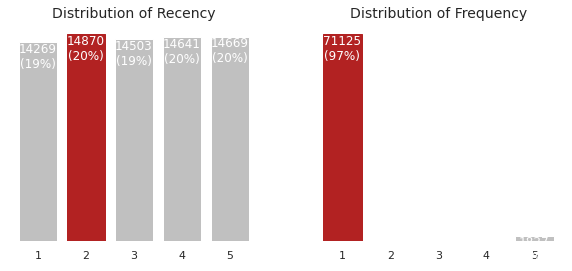

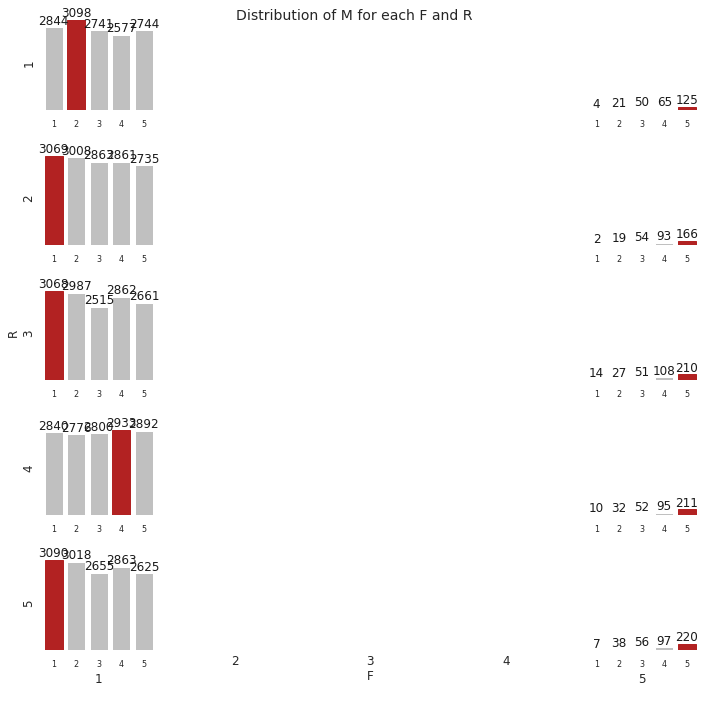

In [92]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()